Plug-and-Play ADMM Consensus Demosaicing
========================================

This example demonstrates the use of class [admm.ppp.PPPConsensus](http://sporco.rtfd.org/en/latest/modules/sporco.admm.ppp.html#sporco.admm.ppp.PPPConsensus) for solving a raw image demosaicing problem via an ADMM Consensus implementation of the Multi-Agent Consensus Equilibrium approach [[10]](http://sporco.rtfd.org/en/latest/zreferences.html#buzzard-2018-plug).

In [1]:
from __future__ import print_function
from builtins import input, range

import numpy as np
from scipy.sparse.linalg import LinearOperator

from bm3d import bm3d_rgb
try:
    from colour_demosaicing import demosaicing_CFA_Bayer_Menon2007
except ImportError:
    have_demosaic = False
else:
    have_demosaic = True

from sporco.linalg import _cg_wrapper
from sporco.admm.ppp import PPPConsensus
from sporco.interp import bilinear_demosaic
from sporco import metric
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Define demosaicing forward operator and its transpose.

In [2]:
def A(x):
    """Map an RGB image to a single channel image with each pixel
    representing a single colour according to the colour filter array.
    """

    y = np.zeros(x.shape[0:2])
    y[1::2, 1::2] = x[1::2, 1::2, 0]
    y[0::2, 1::2] = x[0::2, 1::2, 1]
    y[1::2, 0::2] = x[1::2, 0::2, 1]
    y[0::2, 0::2] = x[0::2, 0::2, 2]
    return y


def AT(x):
    """Back project a single channel raw image to an RGB image with zeros
    at the locations of undefined samples.
    """

    y = np.zeros(x.shape + (3,))
    y[1::2, 1::2, 0] = x[1::2, 1::2]
    y[0::2, 1::2, 1] = x[0::2, 1::2]
    y[1::2, 0::2, 1] = x[1::2, 0::2]
    y[0::2, 0::2, 2] = x[0::2, 0::2]
    return y

Define baseline demosaicing function. If package [colour_demosaicing](https://github.com/colour-science/colour-demosaicing) is installed, use the demosaicing algorithm of [[37]](http://sporco.rtfd.org/en/latest/zreferences.html#menon-2007-demosaicing), othewise use simple bilinear demosaicing.

In [3]:
if have_demosaic:
    def demosaic(cfaimg):
        return demosaicing_CFA_Bayer_Menon2007(cfaimg, pattern='BGGR')
else:
    def demosaic(cfaimg):
        return bilinear_demosaic(cfaimg)

Load reference image.

In [4]:
img = util.ExampleImages().image('kodim23.png', scaled=True,
                                 idxexp=np.s_[160:416,60:316])

Construct test image constructed by colour filter array sampling and adding Gaussian white noise.

In [5]:
np.random.seed(12345)
s = A(img)
rgbshp = s.shape + (3,)  # Shape of reconstructed RGB image
rgbsz = s.size * 3       # Size of reconstructed RGB image
nsigma = 2e-2            # Noise standard deviation
sn = s + nsigma * np.random.randn(*s.shape)

Define proximal operator of data fidelity term for PPP problem.

In [6]:
def proxf(x, rho, tol=1e-3, maxit=100):
    ATA = lambda z: AT(A(z))
    ATAI = lambda z: ATA(z.reshape(rgbshp)).ravel() + rho * z.ravel()
    lop = LinearOperator((rgbsz, rgbsz), matvec=ATAI, dtype=s.dtype)
    b = AT(sn) + rho * x
    vx, cgit = _cg_wrapper(lop, b.ravel(), None, tol, maxit)
    return vx.reshape(rgbshp)

Define proximal operator of (implicit, unknown) regularisation term for PPP problem. In this case we use BM3D [[18]](http://sporco.rtfd.org/en/latest/zreferences.html#dabov-2008-image) as the denoiser, using the [code](https://pypi.org/project/bm3d) released with [[35]](http://sporco.rtfd.org/en/latest/zreferences.html#makinen-2019-exact).

In [7]:
bsigma = 7.5e-2  # Denoiser parameter

def proxg(x, rho):
    return bm3d_rgb(x, bsigma)

Construct a baseline solution and initaliser for the PPP solution by BM3D denoising of a simple bilinear demosaicing solution. The `3 * nsigma` denoising parameter for BM3D is chosen empirically for best performance.

In [8]:
imgb = bm3d_rgb(demosaic(sn), 3 * nsigma)

Set algorithm options for PPP solver, including use of bilinear demosaiced solution as an initial solution.

In [9]:
opt = PPPConsensus.Options({'Verbose': True, 'RelStopTol': 1e-3,
                            'MaxMainIter': 10, 'rho': 1.5e-1, 'Y0': imgb})

Create solver object and solve, returning the the demosaiced image ``imgp``.

This problem is not ideal as a demonstration of the utility of the Multi-Agent Consensus Equilibrium approach [[10]](http://sporco.rtfd.org/en/latest/zreferences.html#buzzard-2018-plug) because we only have two "agents", corresponding to the proximal operators of the forward and prior models.

It is also worth noting that there are two different ways of implementing this problem as a PPP ADMM Consensus problem. In the first of these, corresponding more closely to the original Multi-Agent Consensus Equilibrium approach, the solver object initialisation would be

```python
b = PPPConsensus(img.shape, (proxf, proxg), opt=opt)
```

The second form, below, is used in this example because it exhibits substantially faster convergence for this problem.

In [10]:
b = PPPConsensus(img.shape, (proxf,), proxg=proxg, opt=opt)
imgp = b.solve()

Itn   r         s       
------------------------


   0  2.63e-02  4.92e-01


   1  2.24e-02  9.20e-02


   2  1.72e-02  7.33e-02


   3  1.33e-02  9.10e-02


   4  1.09e-02  8.99e-02


   5  9.73e-03  7.19e-02


   6  8.95e-03  4.83e-02


   7  7.84e-03  3.08e-02


   8  6.49e-03  3.06e-02


   9  5.43e-03  3.56e-02
------------------------


Display solve time and demosaicing performance.

In [11]:
print("PPP ADMM Consensus solve time: %5.2f s" % b.timer.elapsed('solve'))
print("Baseline demosaicing PSNR:     %5.2f dB" % metric.psnr(img, imgb))
print("PPP demosaicing PSNR:          %5.2f dB" % metric.psnr(img, imgp))

PPP ADMM Consensus solve time: 35.58 s
Baseline demosaicing PSNR:     35.98 dB
PPP demosaicing PSNR:          37.05 dB


Display reference and demosaiced images.

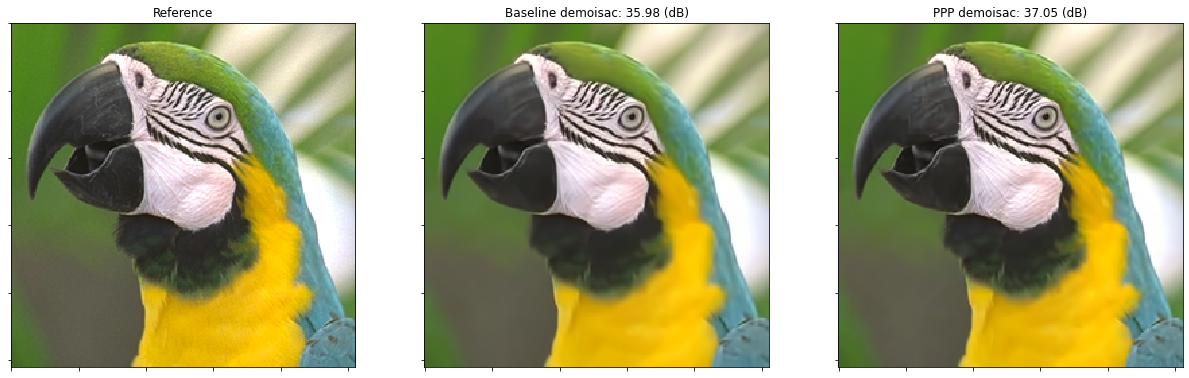

In [12]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=True,
                        figsize=(21, 7))
plot.imview(img, title='Reference', fig=fig, ax=ax[0])
plot.imview(imgb, title='Baseline demoisac: %.2f (dB)' %
            metric.psnr(img, imgb), fig=fig, ax=ax[1])
plot.imview(imgp, title='PPP demoisac: %.2f (dB)' %
            metric.psnr(img, imgp), fig=fig, ax=ax[2])
fig.show()